In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import plotly.express as px

In [28]:
# Load the dataset
df = pd.read_excel("Raw Data/raw_data.xlsx")
print(df.dtypes)

country                      object
year                          int64
control_of_corruption       float64
government_effectiveness    float64
political_stability         float64
rule_of_law                 float64
regulatory_quality          float64
voice_and_accountability    float64
FSI_inverted                float64
FIW_inverted                float64
dtype: object


In [29]:
# Check for missing values
missing_per_indicator = df.isna().sum()
print("Missing values per indicator:")
print(missing_per_indicator)

Missing values per indicator:
country                        0
year                           0
control_of_corruption         29
government_effectiveness      30
political_stability           12
rule_of_law                   11
regulatory_quality            31
voice_and_accountability      65
FSI_inverted                1090
FIW_inverted                 726
dtype: int64


In [30]:
# Calculate missing values per country
missing_per_country = (
    df.drop(columns=["country"])
      .isna()
      .groupby(df["country"])
      .sum()
      .sum(axis=1)
)

print("\n Missing values per country:")
print(missing_per_country)


 Missing values per country:
country
Afghanistan               0
Albania                   0
Algeria                   0
American Samoa           42
Andorra                  18
                         ..
Virgin Islands (U.S.)    46
West Bank and Gaza       36
Yemen, Rep.              36
Zambia                    0
Zimbabwe                  0
Length: 214, dtype: int64


In [31]:
# Filter countries based on missing value threshold
numeric_cols = df.select_dtypes(include='number').columns
total_vals_per_country = df.groupby("country")[numeric_cols].size()
missing_vals_per_country = df.groupby("country")[numeric_cols].apply(lambda x: x.isna().sum().sum())

threshold = 0.3  # maximum 30% missing values
valid_countries = (missing_vals_per_country / total_vals_per_country) < threshold

df_filtered = df[df["country"].isin(valid_countries[valid_countries].index)]

print("\nNumber of countries after filtering:", df_filtered["country"].nunique())


Number of countries after filtering: 151


In [32]:
# Interpolate missing values
df_interpolated = (
    df_filtered
    .sort_values(["country", "year"])
    .reset_index(drop=True)
        .ffill()
        .bfill()
)

# Check missing values after interpolation
missing_after_interpolation = df_interpolated.isna().sum()
print("Missing values per indicator after interpolation:")
print(missing_after_interpolation)

Missing values per indicator after interpolation:
country                     0
year                        0
control_of_corruption       0
government_effectiveness    0
political_stability         0
rule_of_law                 0
regulatory_quality          0
voice_and_accountability    0
FSI_inverted                0
FIW_inverted                0
dtype: int64


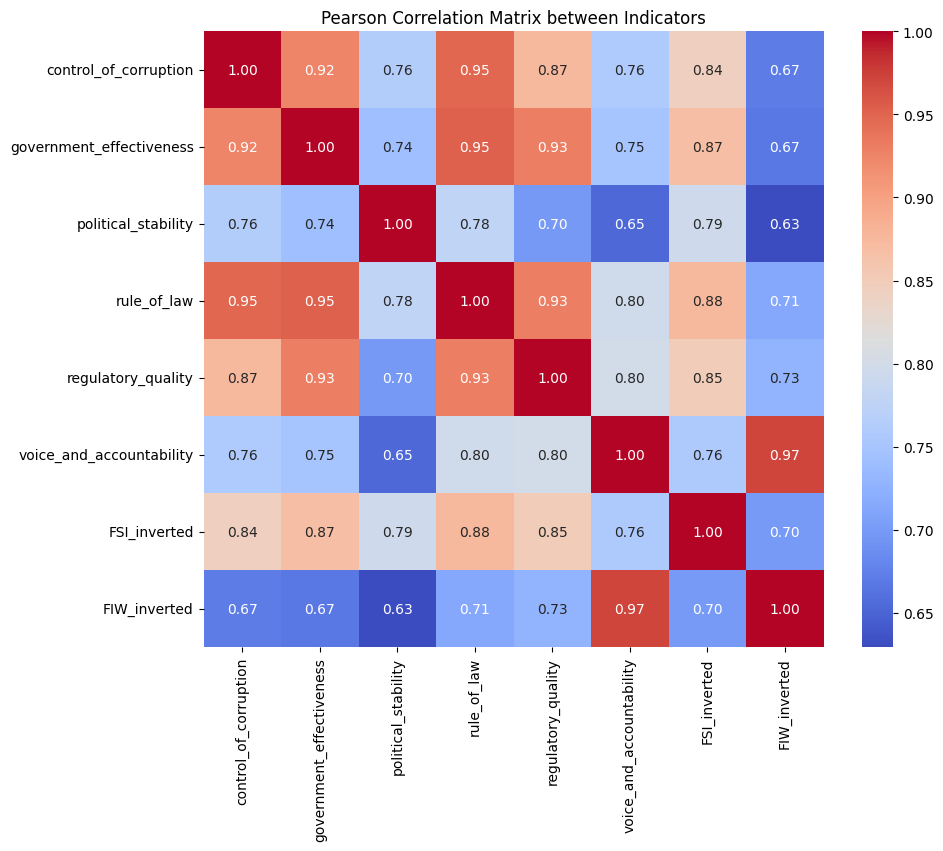

In [33]:
# Calculate and plot correlation matrix
correlation_matrix = df_interpolated.select_dtypes(include='number').drop(columns=["year"]).corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Matrix between Indicators")
plt.show()


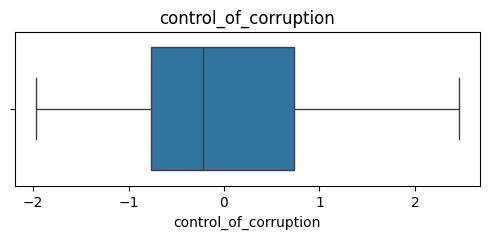

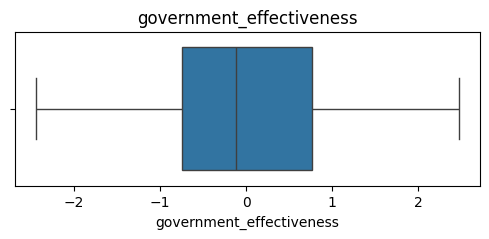

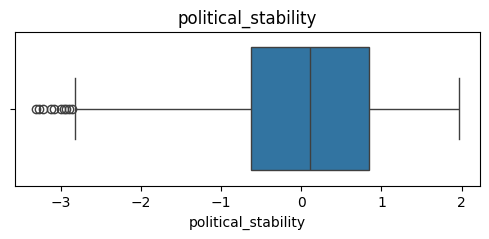

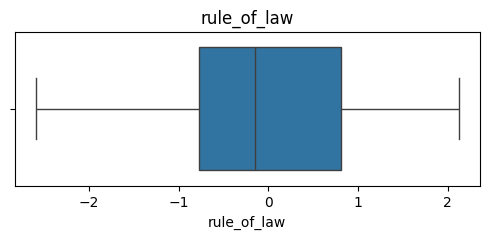

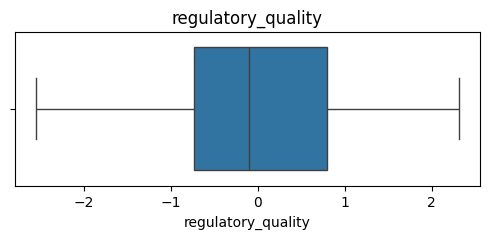

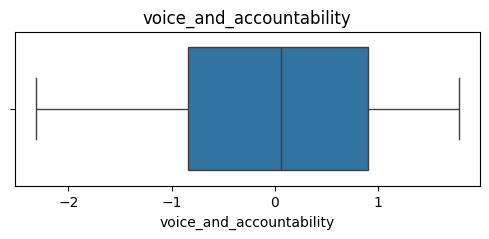

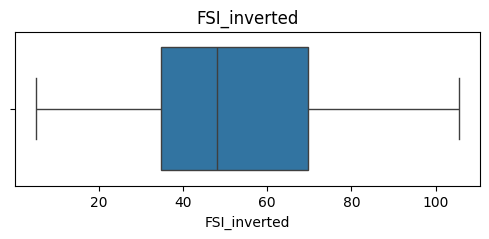

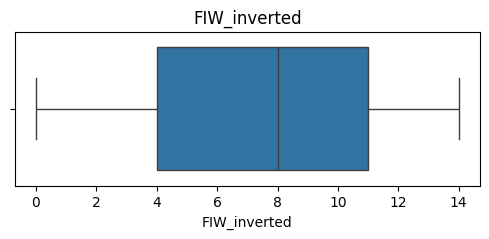

In [34]:
# Plot boxplots for each numeric indicator
for col in df_interpolated.select_dtypes(include='number').columns.drop("year"):
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()   

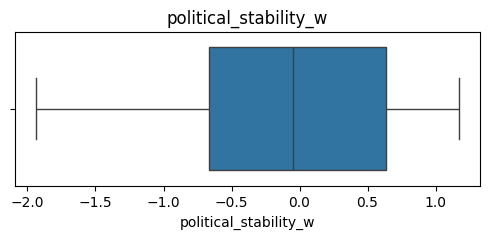

In [35]:
# Winsorize 5% outliers for the indicator political_stability
df_interpolated['political_stability_w'] = winsorize(
    df_interpolated['political_stability'],
    limits=[0.05, 0.05]
).data 

df_interpolated.to_csv("Processed Data/filled_missing_data.csv", index=False)

# Plot boxplot for the winsorized political_stability indicator
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_interpolated['political_stability_w'])
plt.title('political_stability_w')
plt.show()

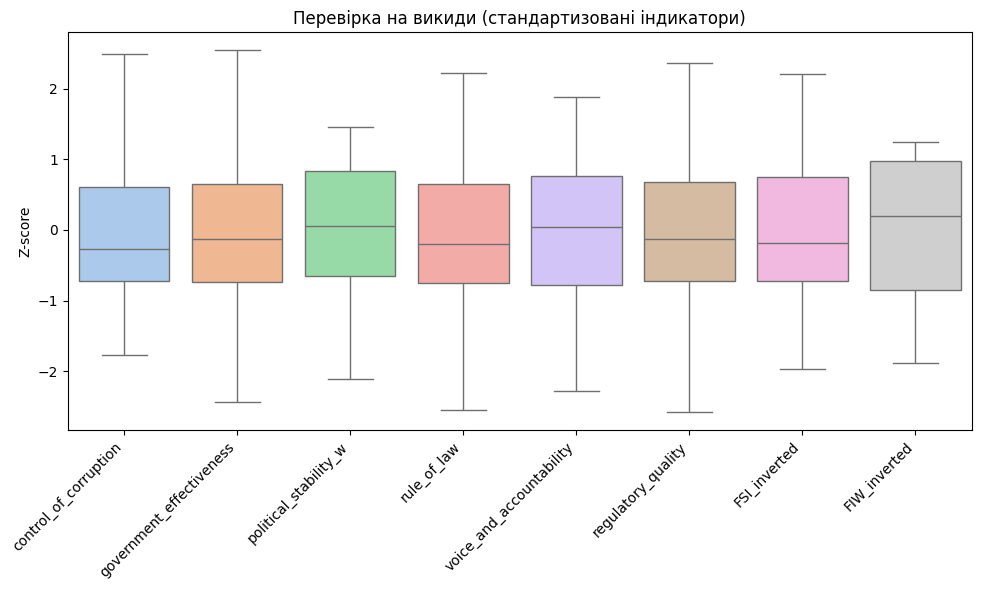

In [ ]:
# Normalization using StandardScaler
feature_cols = [
    "control_of_corruption",
    "government_effectiveness",
    "political_stability_w", 
    "rule_of_law",
    "voice_and_accountability",
    "regulatory_quality",
    "FSI_inverted",
    "FIW_inverted",
]

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(df_interpolated[feature_cols]),
    columns=feature_cols
)

# Save normalized data
df_norm = df_interpolated[['country', 'year']].copy()
df_norm[feature_cols] = X_scaled
df_norm.to_csv("Processed Data/normalized_indicators.csv", index=False)

# Check for outliers in standardized data
cols = df_norm.select_dtypes(include='number').columns.drop('year')

# Create a new dataframe with only these columns
df_numeric = df_norm[cols]
# Plot a single graph with boxplots for all numeric indicators
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_numeric, palette="pastel")

plt.title("Check for Outliers (Standardized Indicators)", fontsize=12)
plt.ylabel("Z-score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [37]:
# PCA to reduce dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=0.90) # Enough to retain 90% of variance
X_pca = pca.fit_transform(X_scaled)
print("Number of components after PCA:", pca.n_components_)
print("Variance ratio explained by each component:", pca.explained_variance_ratio_)
print("Total explained variance ratio:", sum(pca.explained_variance_ratio_))

Number of components after PCA: 2
Variance ratio explained by each component: [0.82650324 0.08095116]
Total explained variance ratio: 0.9074543963343076


In [38]:
# Weight coefficients of PCA
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=feature_cols
)
print(loadings)

# Explained variance percentage by each principal component
explained = pca.explained_variance_ratio_  
explained_percent = explained * 100        
for i, v in enumerate(explained_percent, start=1):
    print(f"PC{i}: {v:.1f}%")


                               PC1       PC2
control_of_corruption     0.364595 -0.242741
government_effectiveness  0.367264 -0.266042
political_stability_w     0.323603 -0.187980
rule_of_law               0.375562 -0.192191
voice_and_accountability  0.345849  0.551017
regulatory_quality        0.365541 -0.098180
FSI_inverted              0.358642 -0.153530
FIW_inverted              0.323366  0.679113
PC1: 82.7%
PC2: 8.1%


control_of_corruption       0.129086
government_effectiveness    0.130032
political_stability_w       0.114573
rule_of_law                 0.132969
voice_and_accountability    0.122450
regulatory_quality          0.129422
FSI_inverted                0.126979
FIW_inverted                0.114489
dtype: float64


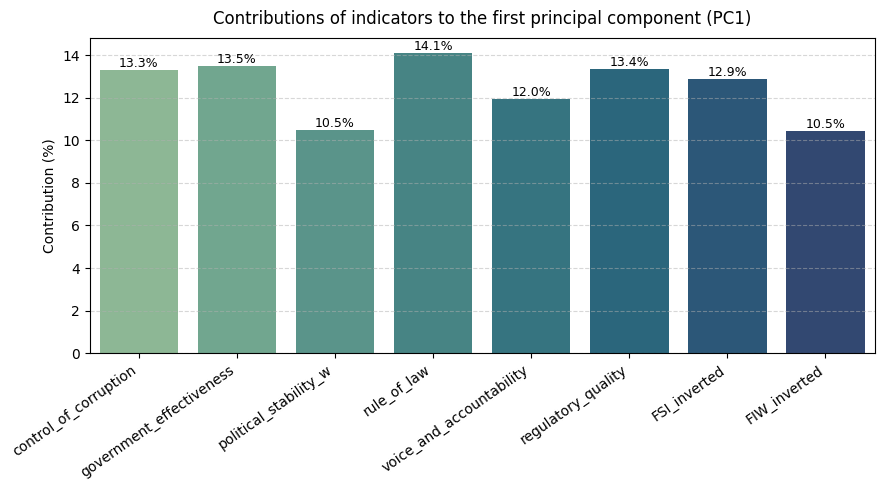

In [39]:
# Weight coefficients for the first principal component (PC1)
loadings = pca.components_[0]   # loadings for PC1
weights_raw = pd.Series(loadings, index=feature_cols)

weights = weights_raw.abs()
weights = weights / weights.sum()  
print(weights)

# Save weights to a table
weights_df = pd.DataFrame({
    "feature": feature_cols,
    "weight": weights 
})

weights_df.to_csv("Processed Data/weights_table.csv", index=False)
# Weight contributions of indicators to principal components
contrib = pca.components_.T ** 2
contrib_percent = contrib / contrib.sum(axis=0) * 100

# Create a contributions table
contrib_df = pd.DataFrame(contrib_percent, index=cols, columns=[f"PC{i+1}" for i in range(contrib_percent.shape[1])])

# Visualization of contributions for the first component
plt.figure(figsize=(9, 5))
sns.barplot(
    x=contrib_df.index,
    y=contrib_df["PC1"],
    hue=contrib_df.index,
    palette="crest",
    legend=False            
)


for p in plt.gca().patches:
    ax = plt.gca()
    value = p.get_height()
    ax.annotate(f'{value:.1f}%',               
                (p.get_x() + p.get_width() / 2, value),  
                ha='center', va='bottom',      
                fontsize=9, color='black')

plt.title("Contributions of indicators to the first principal component (PC1)", fontsize=12, pad=10)
plt.ylabel("Contribution (%)")
plt.xlabel("")
plt.xticks(rotation=35, ha='right')
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [40]:
# Calculate Composite Index (CI) using weights
X_scaled["Composite_Index"] = (X_scaled[feature_cols] * weights).sum(axis=1)
formula_text = "CI = " + " + ".join([f"{w:.3f} * z({col})" for col, w in weights.items()])
print(formula_text)

CI = 0.129 * z(control_of_corruption) + 0.130 * z(government_effectiveness) + 0.115 * z(political_stability_w) + 0.133 * z(rule_of_law) + 0.122 * z(voice_and_accountability) + 0.129 * z(regulatory_quality) + 0.127 * z(FSI_inverted) + 0.114 * z(FIW_inverted)


In [41]:
df_index = df_norm[["country", "year"]].copy()
df_index["Composite_Index"] = X_scaled["Composite_Index"]

# Rank Composite Index to 0-100 scale
CI = df_index["Composite_Index"]
df_index["Composite_Index_0_100"] = 100 * (CI - CI.min()) / (CI.max() - CI.min())
print("\nFirst 5 rows with composite index:")
print(df_index[["Composite_Index", "Composite_Index_0_100"]].head())

# Save the result to a file
df_index.to_csv("Processed Data/composite_index_ranked.csv", index=False)

# Country with the highest composite index in 2006
df_2006 = df_index[df_index["year"] == 2006]
top_country = df_2006.loc[df_2006["Composite_Index_0_100"].idxmax()]
print("\nCountry with the highest composite index in 2006:")
print(top_country)


First 5 rows with composite index:
   Composite_Index  Composite_Index_0_100
0        -1.472363              16.420377
1        -1.494844              15.863386
2        -1.567553              14.061966
3        -1.624214              12.658136
4        -1.621357              12.728921

Country with the highest composite index in 2006:
country                    Denmark
year                          2006
Composite_Index           1.858795
Composite_Index_0_100    98.952756
Name: 702, dtype: object


In [42]:
# Calculate Composite Index (CI) with equal weights
equal_weights = pd.Series(1 / len(feature_cols), index=feature_cols)
X_scaled["Composite_Index_Equal_Weights"] = (X_scaled[feature_cols] * equal_weights).sum(axis=1)
formula_text_equal = "CI_eq = " + " + ".join([f"{w:.3f} * z({col})" for col, w in equal_weights.items()])
print(formula_text_equal)

CI_eq = 0.125 * z(control_of_corruption) + 0.125 * z(government_effectiveness) + 0.125 * z(political_stability_w) + 0.125 * z(rule_of_law) + 0.125 * z(voice_and_accountability) + 0.125 * z(regulatory_quality) + 0.125 * z(FSI_inverted) + 0.125 * z(FIW_inverted)


Correlation between PCA Composite Index and Equal Weights Composite Index: 1.000


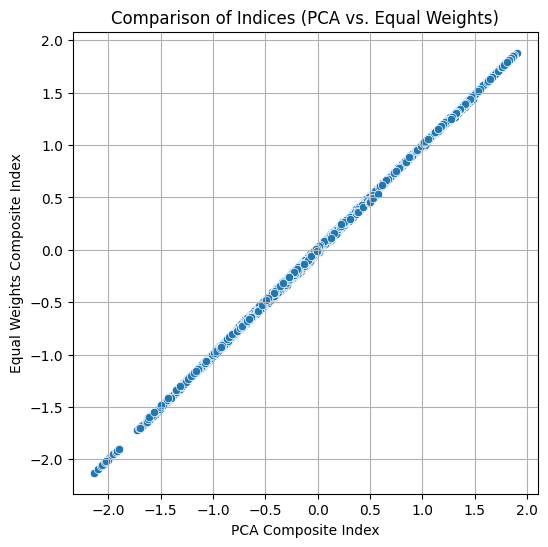

Average difference in rankings: 8.491537895511405
Maximum difference in rankings: 82.0


In [43]:
# Compare PCA Composite Index with Equal Weights Composite Index
corr = X_scaled["Composite_Index"].corr(X_scaled["Composite_Index_Equal_Weights"])
print(f"Correlation between PCA Composite Index and Equal Weights Composite Index: {corr:.3f}")

# Scatter plot  
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x=X_scaled["Composite_Index"],
    y=X_scaled["Composite_Index_Equal_Weights"]
)
plt.xlabel("PCA Composite Index")
plt.ylabel("Equal Weights Composite Index")
plt.title("Comparison of Indices (PCA vs. Equal Weights)")
plt.grid(True)
plt.show()

# Comparison of rankings
rank_pca = X_scaled["Composite_Index"].rank(ascending=False)
rank_eq = X_scaled["Composite_Index_Equal_Weights"].rank(ascending=False)
rank_diff = (rank_pca - rank_eq).abs()
print("Average difference in rankings:", rank_diff.mean())
print("Maximum difference in rankings:", rank_diff.max())

Number of components after PCA (MinMax): 2
Explained variance ratio by each component (MinMax): [0.80608552 0.10185673]
Total explained variance ratio (MinMax): 0.9079422467854021
                               PC1       PC2
control_of_corruption     0.347520 -0.263850
government_effectiveness  0.297273 -0.228883
political_stability_w     0.381626 -0.347941
rule_of_law               0.320008 -0.195307
voice_and_accountability  0.355417  0.412617
regulatory_quality        0.299398 -0.106548
FSI_inverted              0.352248 -0.214026
FIW_inverted              0.450306  0.700982
control_of_corruption       0.347520
government_effectiveness    0.297273
political_stability_w       0.381626
rule_of_law                 0.320008
voice_and_accountability    0.355417
regulatory_quality          0.299398
FSI_inverted                0.352248
FIW_inverted                0.450306
dtype: float64
control_of_corruption       0.123946
government_effectiveness    0.106025
political_stability_w       0.

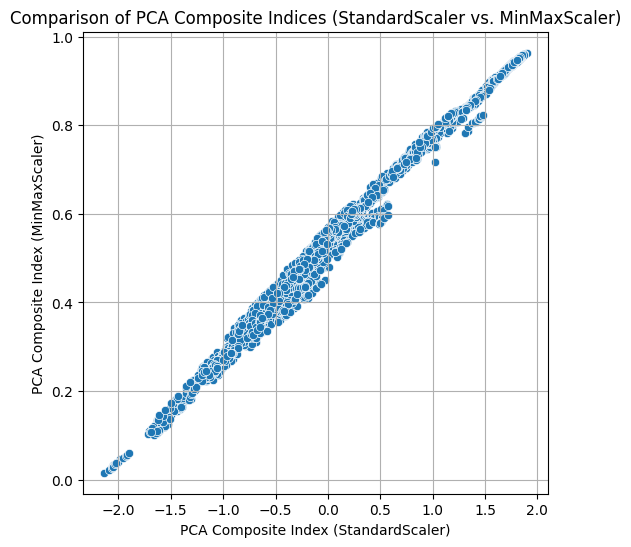

In [44]:
# Use MinMaxScaler instead of StandardScaler
minmax_scaler = MinMaxScaler()
X_minmax_scaled = pd.DataFrame(
    minmax_scaler.fit_transform(df_interpolated[feature_cols]),
    columns=feature_cols
)

# PCA on MinMax scaled data
pca_minmax = PCA(n_components=0.90)
X_pca_minmax = pca_minmax.fit_transform(X_minmax_scaled)
print("Number of components after PCA (MinMax):", pca_minmax.n_components_)
print("Explained variance ratio by each component (MinMax):", pca_minmax.explained_variance_ratio_)
print("Total explained variance ratio (MinMax):", sum(pca_minmax.explained_variance_ratio_))
# PCA loadings for MinMax scaled data
loadings_minmax = pd.DataFrame(
    pca_minmax.components_.T,
    columns=[f"PC{i+1}" for i in range(pca_minmax.n_components_)],
    index=feature_cols
)
print(loadings_minmax)
# Weight coefficients for the first principal component (PC1) using MinMax scaled data
loadings_minmax = pca_minmax.components_[0]   # loadings for PC1
weights_raw_minmax = pd.Series(loadings_minmax, index=feature_cols)
print(weights_raw_minmax)
weights_minmax = weights_raw_minmax.abs()
weights_minmax = weights_minmax / weights_minmax.sum()   # normalization so that the sum is 1
print(weights_minmax)
# Calculate composite indicator
X_minmax_scaled["Composite_Index_MinMax"] = (X_minmax_scaled[feature_cols] * weights_minmax).sum(axis=1)
formula_text_minmax = "CI_minmax = " + " + ".join([f"{w:.3f} * z({col})" for col, w in weights_minmax.items()])
print(formula_text_minmax)
# Normalize composite indicator to a 0-100 scale
CI_minmax = X_minmax_scaled["Composite_Index_MinMax"]
X_minmax_scaled["Composite_Index_MinMax_0_100"] = 100 * (CI_minmax - CI_minmax.min()) / (CI_minmax.max() - CI_minmax.min())
# Comparison of PCA on StandardScaler and MinMaxScaler
corr_minmax = X_scaled["Composite_Index"].corr(X_minmax_scaled["Composite_Index_MinMax"])
print(f"Correlation between PCA index (StandardScaler) and PCA index (MinMaxScaler): {corr_minmax:.3f}")
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x=X_scaled["Composite_Index"],
    y=X_minmax_scaled["Composite_Index_MinMax"]
)
plt.xlabel("PCA Composite Index (StandardScaler)")
plt.ylabel("PCA Composite Index (MinMaxScaler)")
plt.title("Comparison of PCA Composite Indices (StandardScaler vs. MinMaxScaler)")
plt.grid(True)
plt.show()



In [45]:
# PCA Transformation on the original scaled data
df_pca_input = X_scaled.drop(columns=[
    "Composite_Index",
    "Composite_Index_Equal_Weights"
], errors="ignore")

X = df_pca_input[scaler.feature_names_in_]
X_scaled = scaler.transform(X)
X_pca = pca.transform(X_scaled)


X_pca = pca.transform(df_pca_input)
# Create a DataFrame for PCA results
df_pca = pd.DataFrame(
    X_pca, 
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

#  Add country column for reference
df_pca["country"] = df_interpolated["country"].values

df_pca.head()

,PC1,PC2,country
0,-4.158575,0.665141,Afghanistan
1,-4.222071,0.738836,Afghanistan
2,-4.427431,0.556200,Afghanistan
3,-4.587466,0.246402,Afghanistan
4,-4.579397,0.235415,Afghanistan


In [46]:
# K-Means Clustering on PCA results
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(df_pca[['PC1', 'PC2']])

# Add cluster labels to the DataFrame
df_pca['cluster'] = clusters

cluster_means = df_pca.groupby('cluster')[['PC1', 'PC2']].mean()
order = cluster_means.mean(axis=1).sort_values().index

# Map cluster numbers to descriptive names
cluster_names = {
    order[0]: "Low stability and weak governance",
    order[1]: "Medium stability and governance",
    order[2]: "High stability and effective governance"
}

df_pca['cluster_name'] = df_pca['cluster'].map(cluster_names)

df_pca.to_csv("Processed Data/clustered_countries.csv", index=False)

print("\nExample of the first clustered countries:")
print(df_pca.head())


Example of the first clustered countries:
        PC1       PC2      country  cluster                       cluster_name
0 -4.158575  0.665141  Afghanistan        1  Low stability and weak governance
1 -4.222071  0.738836  Afghanistan        1  Low stability and weak governance
2 -4.427431  0.556200  Afghanistan        1  Low stability and weak governance
3 -4.587466  0.246402  Afghanistan        1  Low stability and weak governance
4 -4.579397  0.235415  Afghanistan        1  Low stability and weak governance


In [47]:
# Clustering results are located in the Processed Data folder in the files clustered_countries.csv and clustered_countries.png
# Cluster colors
cluster_colors = {     
    "Low stability and weak governance": "#b81e0c",  
    "High stability and effective governance": "#006e2e",     
    "Medium stability and governance": "#e6b804"       
}

fig = px.choropleth(
    df_pca,
    locations="country",
    locationmode="country names",
    color="cluster_name",
    color_discrete_map=cluster_colors,
    title="Clusters of countries by political stability and governance effectiveness",
    projection="natural earth"
)

fig.update_layout(
    geo=dict(
        showcountries=True,
        showcoastlines=True,
        showland=True,
        landcolor="lightgray"
    ),
    paper_bgcolor="white",
    plot_bgcolor="white"
)
fig.update_layout(legend_title_text="Cluster Names")

import plotly.io as pio
pio.renderers.default = "browser"

fig.show()